In [112]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
plt.style.use('seaborn-colorblind')
plt.rc('axes', grid=True)
plt.rc('savefig', format='png', facecolor='None')

In [113]:
# Read in pre-processed pickle
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f:
    rpi = pickle.load(f)

In [114]:
rpi = rpi.sort_values(by=['census_cbsa_geoid', 'census_zcta5_geoid', 'date'])
rpi

,date,census_cbsa_geoid,census_zcta5_geoid,sfr_rental_index,sfr_price_index,coef,nounits,occupied_units,mfr_occ,mfr_mean_occ_index,mfr_mean_rent,mfr_mean_rent_index,month,cos_month,sin_month,sfr_rental_delta,sfr_price_delta,mfr_occ_delta,mfr_rental_delta,us_zip,population,student_population_fraction,netflow_estimated,inflow_estimated,outflow_estimated,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,inflow_index,outflow_index,netflow_index,income_inflow_index,income_diff_index,age_inflow_index,age_inflow_diff_index
0,2010-01-01,12060,30002,100.000000,74.294071,-0.311687,NaN,NaN,NaN,NaN,NaN,NaN,1,8.660254e-01,5.000000e-01,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-02-01,12060,30002,102.656397,73.790885,-0.308921,NaN,NaN,NaN,NaN,NaN,NaN,2,5.000000e-01,8.660254e-01,2.656397,-0.503185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-03-01,12060,30002,99.927026,73.500102,-0.329055,NaN,NaN,NaN,NaN,NaN,NaN,3,6.123234e-17,1.000000e+00,-2.729372,-0.290783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-04-01,12060,30002,100.890119,72.837599,-0.330161,NaN,NaN,NaN,NaN,NaN,NaN,4,-5.000000e-01,8.660254e-01,0.963094,-0.662503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-05-01,12060,30002,102.552376,72.728859,-0.311771,NaN,NaN,NaN,NaN,NaN,NaN,5,-8.660254e-01,5.000000e-01,1.662257,-0.108740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36075,2023-04-01,17460,44333,172.815363,136.885857,0.371038,354.0,349.008,0.985898,100.007450,1207.057143,124.438881,4,-5.000000e-01,8.660254e-01,0.921771,1.030017,0.000000,0.295042,44333,19004.0,0.038,18.0,123.0,105.0,825.0,50757.8516,93292.0,-42534.1484,31.5727,47.4,-15.8273,1.016529,0.690789,-0.580645,0.951640,1.064558,0.917720,1.217803
36076,2023-05-01,17460,44333,174.151339,138.688638,0.373829,354.0,348.008,0.983073,99.720903,1206.419048,124.373098,5,-8.660254e-01,5.000000e-01,1.335976,1.802781,-0.286548,-0.065783,44333,19004.0,0.038,95.0,175.0,80.0,920.0,54563.5039,93292.0,-38728.4961,29.9224,47.4,-17.4776,1.446281,0.526316,-3.064516,1.022991,0.969309,0.869751,1.344782
36077,2023-06-01,17460,44333,174.005400,139.556130,0.360819,354.0,348.008,0.983073,99.720903,1189.680952,122.647521,6,-1.000000e+00,1.224647e-16,-0.145938,0.867492,0.000000,-1.725577,44333,19004.0,0.038,23.0,103.0,80.0,943.0,57836.4570,93292.0,-35455.5430,32.5261,47.4,-14.8739,0.851240,0.526316,-0.741935,1.084354,0.887392,0.945433,1.144445
36078,2023-07-01,17460,44333,175.427516,143.152874,0.425997,NaN,NaN,NaN,NaN,NaN,NaN,7,-8.660254e-01,-5.000000e-01,1.422116,3.596744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
all_zips = rpi['census_zcta5_geoid'].unique().tolist()
print(all_zips[:144])
print(len(all_zips))

['30002', '30004', '30005', '30008', '30009', '30011', '30012', '30013', '30014', '30016', '30017', '30019', '30021', '30022', '30024', '30028', '30030', '30032', '30033', '30034', '30035', '30038', '30039', '30040', '30041', '30043', '30044', '30045', '30046', '30047', '30052', '30058', '30060', '30062', '30064', '30066', '30067', '30068', '30071', '30075', '30076', '30080', '30082', '30083', '30084', '30087', '30088', '30092', '30093', '30094', '30096', '30097', '30101', '30102', '30106', '30114', '30115', '30116', '30117', '30120', '30121', '30122', '30126', '30132', '30134', '30135', '30141', '30144', '30152', '30157', '30168', '30180', '30188', '30189', '30204', '30213', '30214', '30215', '30223', '30224', '30228', '30233', '30236', '30238', '30240', '30241', '30248', '30252', '30253', '30260', '30263', '30265', '30269', '30274', '30281', '30291', '30294', '30296', '30297', '30303', '30305', '30306', '30307', '30308', '30309', '30310', '30311', '30312', '30313', '30314', '30315', 

In [116]:
# subset relevant columns
df = rpi[['date', 'census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index', 'sfr_price_index', 'nounits', 'mfr_occ', 'mfr_mean_rent']].copy()

# subset for MFR data time window
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

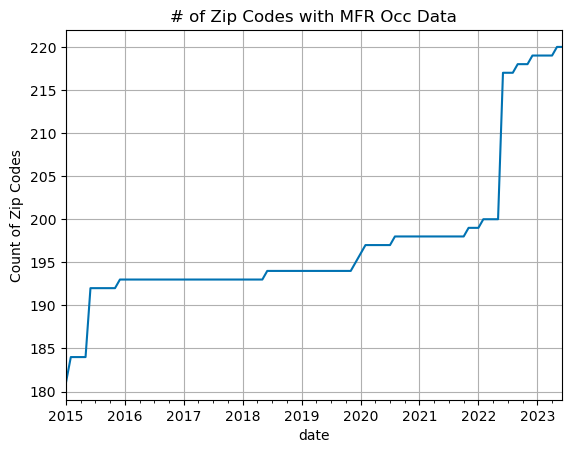

In [117]:
# check for completeness
df.groupby(by='date')['mfr_occ'].count().plot()
plt.title('# of Zip Codes with MFR Occ Data')
plt.ylabel('Count of Zip Codes')
plt.show()

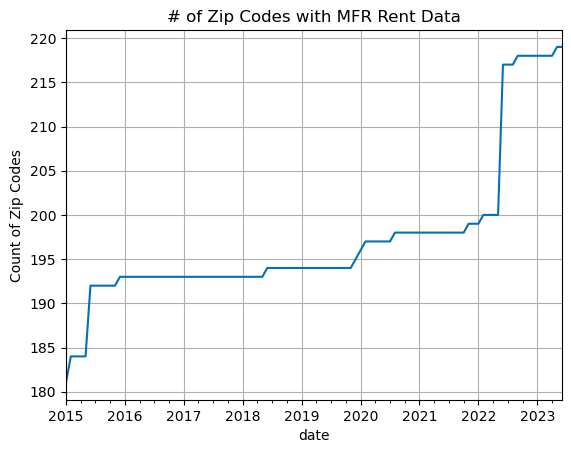

In [118]:
# check for completeness
df.groupby(by='date')['mfr_mean_rent'].count().plot()
plt.title('# of Zip Codes with MFR Rent Data')
plt.ylabel('Count of Zip Codes')
plt.show()

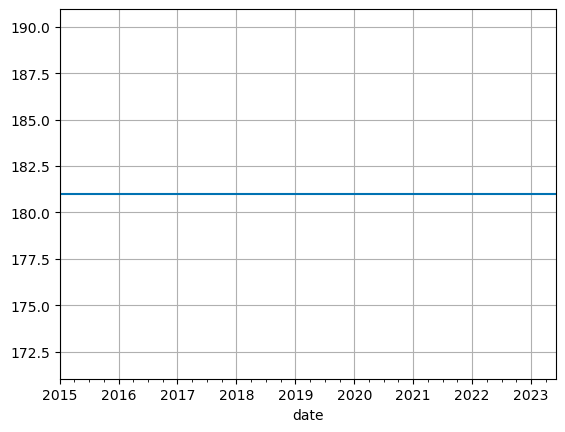

In [119]:
# drop incomplete zips
drops = df.loc[(df.mfr_mean_rent.isna()) | (df.mfr_occ.isna())].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

# check for completeness
df.groupby(by='date')['mfr_occ'].count().plot()
plt.show()

# reset index
df.reset_index(drop=True, inplace=True)

In [120]:
df.to_pickle('final_data.pkl')

# Prophet Model Function

In [8]:
def prophetize(df, label, y='sfr_rental_index', ds='date', train_start='', test_months=6, addl_reg=[]):
    
    # copy dataframe
    df_p = df.copy()
    
    # rename columns for modeling
    df_p.rename(columns = {
        ds:'ds',
        y:'y'
    }, inplace=True)
        
    # create results dictionary 
    result = {
        'zip_code':[],
        'model':[],
        'mape':[],
        'mae':[],
        'rmse':[]
    }
    
    if train_start == '':
        train_start = df_p['ds'].min()
    
    for z in df_p['census_zcta5_geoid'].unique():
        
        # subset for zip code
        df_z = df_p.loc[(df_p['census_zcta5_geoid'] == z) & (df_p['ds'] >= train_start)]
        
        # determine index value for train/test split based on 'p'
        split_idx = len(df_z) - test_months

        # split data
        train = df_z.iloc[:split_idx]
        test = df_z.iloc[split_idx:]
    
        # instantiate and fit model
        m = Prophet() 
        for r in addl_reg:
            m.add_regressor(r)
        m.fit(train[['ds', 'y'] + addl_reg]) # fit model
        
        # create future dataframe
        future = df_z[['ds'] + addl_reg]
    
        # create forecast
        forecast = m.predict(future)
        
        # calculate MAE and MSE
        mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[split_idx:,'yhat']))
        mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[split_idx:,'yhat']))
        rmse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[split_idx:,'yhat']), squared=False)
        
        
        # add to dict
        result['zip_code'].append(z)
        result['model'].append(label)
        result['mape'].append(mape)
        result['mae'].append(mae)
        result['rmse'].append(rmse)
        
        
    return pd.DataFrame.from_dict(result)

# Atlanta - by Zip Code

In [9]:
# subset for Atlanta zip codes
df_atl = df.loc[df['census_cbsa_geoid'] == '12060'].copy()
df_atl.reset_index(drop=True, inplace=True)
df_atl

,date,census_cbsa_geoid,census_zcta5_geoid,sfr_rental_index,sfr_price_index,nounits,mfr_occ,mfr_mean_rent
0,2015-01-01,12060,30002,114.715608,82.331231,592.0,0.910372,650.976648
1,2015-02-01,12060,30002,115.155485,82.202391,592.0,0.910372,666.380495
2,2015-03-01,12060,30002,115.694032,82.423472,592.0,0.912581,653.657967
3,2015-04-01,12060,30002,116.181280,83.115012,592.0,0.907426,654.038462
4,2015-05-01,12060,30002,117.000157,84.135504,592.0,0.907426,645.673077
...,...,...,...,...,...,...,...,...
12031,2023-02-01,12060,30519,188.587234,165.750075,2336.0,0.865714,2062.332814
12032,2023-03-01,12060,30519,189.235967,165.614928,2336.0,0.873572,2069.696914
12033,2023-04-01,12060,30519,189.652129,166.378919,2336.0,0.880706,2060.912826
12034,2023-05-01,12060,30519,190.192039,168.114769,2336.0,0.889595,2062.121936


In [10]:
# create models with different exogenous features
df1 = prophetize(df_atl, 'Benchmark')
df2 = prophetize(df_atl, 'MFR Occ', addl_reg=['mfr_occ'])
df3 = prophetize(df_atl, 'MFR Rent', addl_reg=['mfr_mean_rent'])
df4 = prophetize(df_atl, 'MFR Occ & Rent', addl_reg=['mfr_mean_rent', 'mfr_occ'])

11:50:20 - cmdstanpy - INFO - Chain [1] start processing
11:50:20 - cmdstanpy - INFO - Chain [1] done processing
11:50:20 - cmdstanpy - INFO - Chain [1] start processing
11:50:21 - cmdstanpy - INFO - Chain [1] done processing
11:50:21 - cmdstanpy - INFO - Chain [1] start processing
11:50:22 - cmdstanpy - INFO - Chain [1] done processing
11:50:22 - cmdstanpy - INFO - Chain [1] start processing
11:50:22 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:24 - cmdstanpy - INFO - Chain [1] done processing
11:50:24 - cmdstanpy - INFO - Chain [1] start processing
11:50:24 - cmdstanpy - INFO - Chain [1] done processing
11:50:25 - cmdstanpy - INFO - Chain [1] start processing
11:50:26 - cmdstanpy - INFO - Chain [1] done processing
11:50:26 - cmdstanpy - INFO - Chain [1] start processing
11:50:27 - cmdstanpy - INFO - Chain [1] done processing
11:50:27 - cmdstanpy - INFO - Chain [1] start processing
11:50:28 - cmdstanpy - INFO - Chain [1]

11:51:27 - cmdstanpy - INFO - Chain [1] done processing
11:51:27 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:29 - cmdstanpy - INFO - Chain [1] done processing
11:51:29 - cmdstanpy - INFO - Chain [1] start processing
11:51:30 - cmdstanpy - INFO - Chain [1] done processing
11:51:30 - cmdstanpy - INFO - Chain [1] start processing
11:51:31 - cmdstanpy - INFO - Chain [1] done processing
11:51:31 - cmdstanpy - INFO - Chain [1] start processing
11:51:32 - cmdstanpy - INFO - Chain [1] done processing
11:51:32 - cmdstanpy - INFO - Chain [1] start processing
11:51:33 - cmdstanpy - INFO - Chain [1] done processing
11:51:33 - cmdstanpy - INFO - Chain [1] start processing
11:51:34 - cmdstanpy - INFO - Chain [1] done processing
11:51:34 - cmdstanpy - INFO - Chain [1] start processing
11:51:35 - cmdstanpy - INFO - Chain [1] done processing
11:51:35 - cmdstanpy - INFO - Chain [1] 

11:52:34 - cmdstanpy - INFO - Chain [1] done processing
11:52:35 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing
11:52:38 - cmdstanpy - INFO - Chain [1] start processing
11:52:39 - cmdstanpy - INFO - Chain [1] done processing
11:52:39 - cmdstanpy - INFO - Chain [1] start processing
11:52:40 - cmdstanpy - INFO - Chain [1] done processing
11:52:40 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing
11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing
11:52:42 - cmdstanpy - INFO - Chain [1] 

11:53:41 - cmdstanpy - INFO - Chain [1] done processing
11:53:41 - cmdstanpy - INFO - Chain [1] start processing
11:53:42 - cmdstanpy - INFO - Chain [1] done processing
11:53:42 - cmdstanpy - INFO - Chain [1] start processing
11:53:43 - cmdstanpy - INFO - Chain [1] done processing
11:53:43 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:45 - cmdstanpy - INFO - Chain [1] done processing
11:53:45 - cmdstanpy - INFO - Chain [1] start processing
11:53:46 - cmdstanpy - INFO - Chain [1] done processing
11:53:46 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:47 - cmdstanpy - INFO - Chain [1] done processing
11:53:47 - cmdstanpy - INFO - Chain [1] start processing
11:53:48 - cmdstanpy - INFO - Chain [1] done processing
11:53:48 - cmdstanpy - INFO - Chain [1] 

11:54:48 - cmdstanpy - INFO - Chain [1] done processing
11:54:48 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing
11:54:49 - cmdstanpy - INFO - Chain [1] start processing
11:54:49 - cmdstanpy - INFO - Chain [1] done processing
11:54:49 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:52 - cmdstanpy - INFO - Chain [1] done processing
11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing
11:54:53 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing
11:54:54 - cmdstanpy - INFO - Chain [1] start processing
11:54:55 - cmdstanpy - INFO - Chain [1] done processing
11:54:55 - cmdstanpy - INFO - Chain [1] 

11:55:54 - cmdstanpy - INFO - Chain [1] done processing
11:55:54 - cmdstanpy - INFO - Chain [1] start processing
11:55:55 - cmdstanpy - INFO - Chain [1] done processing
11:55:55 - cmdstanpy - INFO - Chain [1] start processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing
11:55:56 - cmdstanpy - INFO - Chain [1] start processing
11:55:57 - cmdstanpy - INFO - Chain [1] done processing
11:55:57 - cmdstanpy - INFO - Chain [1] start processing
11:55:58 - cmdstanpy - INFO - Chain [1] done processing
11:55:58 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:01 - cmdstanpy - INFO - Chain [1] done processing
11:56:01 - cmdstanpy - INFO - Chain [1] start processing
11:56:02 - cmdstanpy - INFO - Chain [1] done processing
11:56:02 - cmdstanpy - INFO - Chain [1] 

11:56:57 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:58 - cmdstanpy - INFO - Chain [1] done processing
11:56:58 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:00 - cmdstanpy - INFO - Chain [1] done processing
11:57:00 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing
11:57:01 - cmdstanpy - INFO - Chain [1] start processing
11:57:02 - cmdstanpy - INFO - Chain [1] done processing
11:57:02 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:03 - cmdstanpy - INFO - Chain [1] start processing
11:57:03 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] start processing
11:57:04 - cmdstanpy - INFO - Chain [1] done processing
11:57:04 - cmdstanpy - INFO - Chain [1] 

In [11]:
# concat results
atl_exo_compare = pd.concat([df1,df2,df3,df4]).reset_index(drop=True)
atl_exo_compare

,zip_code,model,mape,mae,rmse
0,30002,Benchmark,0.043461,8.329495,8.584817
1,30004,Benchmark,0.047396,8.831550,9.035110
2,30005,Benchmark,0.049286,9.483167,9.703968
3,30008,Benchmark,0.052833,10.881943,11.140033
4,30009,Benchmark,0.052330,10.535776,10.775404
...,...,...,...,...,...
467,30354,MFR Occ & Rent,0.041920,9.421485,10.347888
468,30360,MFR Occ & Rent,0.038098,7.402285,7.633340
469,30363,MFR Occ & Rent,0.035412,11.473550,11.707147
470,30518,MFR Occ & Rent,0.044620,8.576134,8.900997


In [ ]:
# commented out so I don't accidentally overwrite the pickle
# atl_exo_compare.to_pickle('atl_exo_compare.pkl')

In [2]:
# read pickle for compare
with open('atl_exo_compare.pkl', "rb") as f:
    atl_exo_compare = pickle.load(f)
    
atl_exo_compare

,zip_code,model,mape,mae,rmse
0,30002,Benchmark,0.043461,8.329495,8.584817
1,30004,Benchmark,0.047396,8.831550,9.035110
2,30005,Benchmark,0.049286,9.483167,9.703968
3,30008,Benchmark,0.052833,10.881943,11.140033
4,30009,Benchmark,0.052330,10.535776,10.775404
...,...,...,...,...,...
467,30354,MFR Occ & Rent,0.041920,9.421485,10.347888
468,30360,MFR Occ & Rent,0.038098,7.402285,7.633340
469,30363,MFR Occ & Rent,0.035412,11.473550,11.707147
470,30518,MFR Occ & Rent,0.044620,8.576134,8.900997


In [11]:
atl_exo_compare['model'].replace('Benchmark', 'Univariate', inplace=True)
atl_exo_compare['model'].replace('MFR Occ', 'MFR Occupancy', inplace=True)

In [12]:
atl_exo_compare.sort_values('mape')

,zip_code,model,mape,mae,rmse
347,30349,MFR Rent,0.001408,0.287074,0.505564
412,30168,MFR Occ & Rent,0.001723,0.358617,0.420243
406,30122,MFR Occ & Rent,0.001790,0.331727,0.416092
465,30349,MFR Occ & Rent,0.001882,0.384481,0.510307
267,30067,MFR Rent,0.001932,0.373476,0.442331
...,...,...,...,...,...
233,30363,MFR Occupancy,0.069379,22.488817,23.012125
115,30363,Univariate,0.070949,22.997661,23.524038
432,30297,MFR Occ & Rent,0.071133,16.373578,17.087229
123,30012,MFR Occupancy,0.072811,23.273311,23.867617


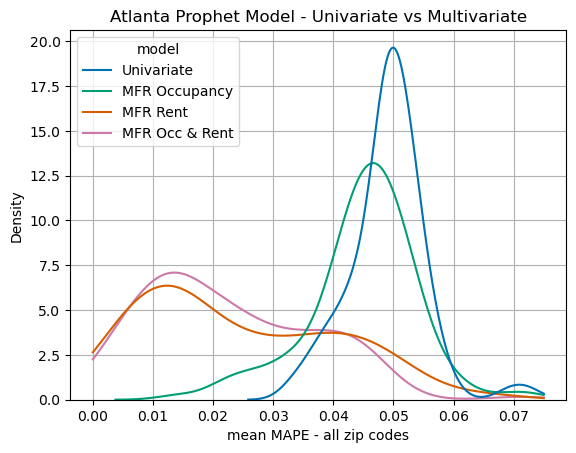

In [16]:
sns.kdeplot(data=atl_exo_compare, x='mape', hue='model', clip=(0,0.075))
plt.title('Atlanta Prophet Model - Univariate vs Multivariate')
plt.xlabel('mean MAPE - all zip codes')
plt.savefig('atl-proph-kde')
plt.show()

In [13]:
bar_plot_atl = atl_exo_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
bar_plot_atl.sort_values('mape', inplace=True)
bar_plot_atl

,model,mape,rmse,mae
2,MFR Occ & Rent,0.022659,4.871332,4.631700
3,MFR Rent,0.024376,5.218187,4.992659
1,MFR Occ,0.044953,9.411931,9.139289
0,Benchmark,0.049078,10.233656,9.976786


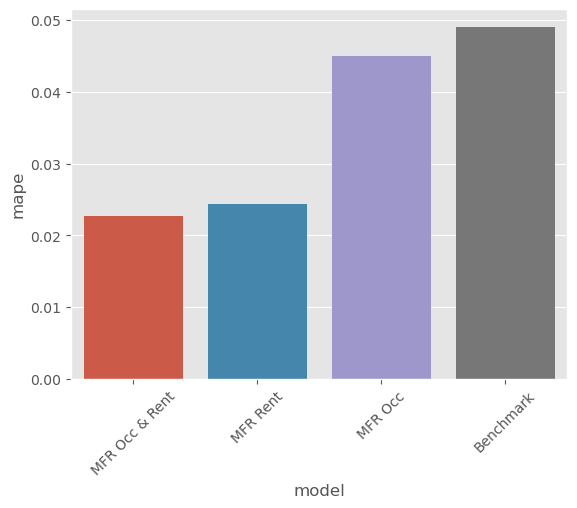

In [58]:
sns.barplot(data=bar_plot_atl, x='model', y='mape')
plt.xticks(rotation=45)
plt.show()

In [16]:
# run models for different time windows using both exogenous variables
dfa6 = prophetize(df_atl, '6 months',  train_start='2022-07-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa9 = prophetize(df_atl, '9 months',  train_start='2022-04-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa12= prophetize(df_atl, '12 months', train_start='2022-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa18= prophetize(df_atl, '18 months', train_start='2021-07-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa24= prophetize(df_atl, '24 months', train_start='2021-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa36= prophetize(df_atl, '36 months', train_start='2020-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa48= prophetize(df_atl, '48 months', train_start='2019-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfa72= prophetize(df_atl, '72 months', train_start='2017-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])

# pull from original model results
dfa96= atl_exo_compare.loc[atl_exo_compare['model'] == 'MFR Occ & Rent'].copy()

# rename model for consitency
dfa96['model'] = '96 months'

13:24:39 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing
13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1]

13:26:20 - cmdstanpy - INFO - Chain [1] done processing
13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:21 - cmdstanpy - INFO - Chain [1] done processing
13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing
13:26:23 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1] done processing
13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:28 - cmdstanpy - INFO - Chain [1] done processing
13:26:28 - cmdstanpy - INFO - Chain [1] start processing
13:26:30 - cmdstanpy - INFO - Chain [1] done processing
13:26:30 - cmdstanpy - INFO - Chain [1] start processing
13:26:32 - cmdstanpy - INFO - Chain [1] done processing
13:26:32 - cmdstanpy - INFO - Chain [1] start processing
13:26:32 - cmdstanpy - INFO - Chain [1] done processing
13:26:33 - cmdstanpy - INFO - Chain [1] start processing
13:26:33 - cmdstanpy - INFO - Chain [1] done processing
13:26:33 - cmdstanpy - INFO - Chain [1] 

13:28:01 - cmdstanpy - INFO - Chain [1] done processing
13:28:01 - cmdstanpy - INFO - Chain [1] start processing
13:28:02 - cmdstanpy - INFO - Chain [1] done processing
13:28:02 - cmdstanpy - INFO - Chain [1] start processing
13:28:03 - cmdstanpy - INFO - Chain [1] done processing
13:28:03 - cmdstanpy - INFO - Chain [1] start processing
13:28:04 - cmdstanpy - INFO - Chain [1] done processing
13:28:04 - cmdstanpy - INFO - Chain [1] start processing
13:28:05 - cmdstanpy - INFO - Chain [1] done processing
13:28:05 - cmdstanpy - INFO - Chain [1] start processing
13:28:07 - cmdstanpy - INFO - Chain [1] done processing
13:28:07 - cmdstanpy - INFO - Chain [1] start processing
13:28:08 - cmdstanpy - INFO - Chain [1] done processing
13:28:08 - cmdstanpy - INFO - Chain [1] start processing
13:28:08 - cmdstanpy - INFO - Chain [1] done processing
13:28:08 - cmdstanpy - INFO - Chain [1] start processing
13:28:09 - cmdstanpy - INFO - Chain [1] done processing
13:28:09 - cmdstanpy - INFO - Chain [1] 

13:29:45 - cmdstanpy - INFO - Chain [1] done processing
13:29:45 - cmdstanpy - INFO - Chain [1] start processing
13:29:46 - cmdstanpy - INFO - Chain [1] done processing
13:29:46 - cmdstanpy - INFO - Chain [1] start processing
13:29:47 - cmdstanpy - INFO - Chain [1] done processing
13:29:47 - cmdstanpy - INFO - Chain [1] start processing
13:29:48 - cmdstanpy - INFO - Chain [1] done processing
13:29:48 - cmdstanpy - INFO - Chain [1] start processing
13:29:48 - cmdstanpy - INFO - Chain [1] done processing
13:29:48 - cmdstanpy - INFO - Chain [1] start processing
13:29:49 - cmdstanpy - INFO - Chain [1] done processing
13:29:49 - cmdstanpy - INFO - Chain [1] start processing
13:29:50 - cmdstanpy - INFO - Chain [1] done processing
13:29:50 - cmdstanpy - INFO - Chain [1] start processing
13:29:50 - cmdstanpy - INFO - Chain [1] done processing
13:29:50 - cmdstanpy - INFO - Chain [1] start processing
13:29:52 - cmdstanpy - INFO - Chain [1] done processing
13:29:52 - cmdstanpy - INFO - Chain [1] 

13:30:41 - cmdstanpy - INFO - Chain [1] done processing
13:30:42 - cmdstanpy - INFO - Chain [1] start processing
13:30:42 - cmdstanpy - INFO - Chain [1] done processing
13:30:42 - cmdstanpy - INFO - Chain [1] start processing
13:30:42 - cmdstanpy - INFO - Chain [1] done processing
13:30:42 - cmdstanpy - INFO - Chain [1] start processing
13:30:42 - cmdstanpy - INFO - Chain [1] done processing
13:30:42 - cmdstanpy - INFO - Chain [1] start processing
13:30:43 - cmdstanpy - INFO - Chain [1] done processing
13:30:43 - cmdstanpy - INFO - Chain [1] start processing
13:30:43 - cmdstanpy - INFO - Chain [1] done processing
13:30:43 - cmdstanpy - INFO - Chain [1] start processing
13:30:43 - cmdstanpy - INFO - Chain [1] done processing
13:30:43 - cmdstanpy - INFO - Chain [1] start processing
13:30:44 - cmdstanpy - INFO - Chain [1] done processing
13:30:44 - cmdstanpy - INFO - Chain [1] start processing
13:30:44 - cmdstanpy - INFO - Chain [1] done processing
13:30:44 - cmdstanpy - INFO - Chain [1] 

13:31:08 - cmdstanpy - INFO - Chain [1] done processing
13:31:08 - cmdstanpy - INFO - Chain [1] start processing
13:31:08 - cmdstanpy - INFO - Chain [1] done processing
13:31:08 - cmdstanpy - INFO - Chain [1] start processing
13:31:08 - cmdstanpy - INFO - Chain [1] done processing
13:31:08 - cmdstanpy - INFO - Chain [1] start processing
13:31:08 - cmdstanpy - INFO - Chain [1] done processing
13:31:08 - cmdstanpy - INFO - Chain [1] start processing
13:31:08 - cmdstanpy - INFO - Chain [1] done processing
13:31:08 - cmdstanpy - INFO - Chain [1] start processing
13:31:09 - cmdstanpy - INFO - Chain [1] done processing
13:31:09 - cmdstanpy - INFO - Chain [1] start processing
13:31:09 - cmdstanpy - INFO - Chain [1] done processing
13:31:09 - cmdstanpy - INFO - Chain [1] start processing
13:31:09 - cmdstanpy - INFO - Chain [1] done processing
13:31:09 - cmdstanpy - INFO - Chain [1] start processing
13:31:09 - cmdstanpy - INFO - Chain [1] done processing
13:31:09 - cmdstanpy - INFO - Chain [1] 

13:31:23 - cmdstanpy - INFO - Chain [1] done processing
13:31:23 - cmdstanpy - INFO - Chain [1] start processing
13:31:23 - cmdstanpy - INFO - Chain [1] done processing
13:31:23 - cmdstanpy - INFO - Chain [1] start processing
13:31:23 - cmdstanpy - INFO - Chain [1] done processing
13:31:23 - cmdstanpy - INFO - Chain [1] start processing
13:31:23 - cmdstanpy - INFO - Chain [1] done processing
13:31:23 - cmdstanpy - INFO - Chain [1] start processing
13:31:23 - cmdstanpy - INFO - Chain [1] done processing
13:31:24 - cmdstanpy - INFO - Chain [1] start processing
13:31:24 - cmdstanpy - INFO - Chain [1] done processing
13:31:24 - cmdstanpy - INFO - Chain [1] start processing
13:31:24 - cmdstanpy - INFO - Chain [1] done processing
13:31:24 - cmdstanpy - INFO - Chain [1] start processing
13:31:24 - cmdstanpy - INFO - Chain [1] done processing
13:31:25 - cmdstanpy - INFO - Chain [1] start processing
13:31:25 - cmdstanpy - INFO - Chain [1] done processing
13:31:25 - cmdstanpy - INFO - Chain [1] 

13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:40 - cmdstanpy - INFO - Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:40 - cmdstanpy - INFO - Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:40 - cmdstanpy - INFO - Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing
13:31:42 - cmdstanpy - INFO - Chain [1] start processing
13:31:42 - cmdstanpy - INFO - Chain [1] done processing
13:31:42 - cmdstanpy - INFO - Chain [1] 

13:31:56 - cmdstanpy - INFO - Chain [1] done processing
13:31:56 - cmdstanpy - INFO - Chain [1] start processing
13:31:57 - cmdstanpy - INFO - Chain [1] done processing
13:31:57 - cmdstanpy - INFO - Chain [1] start processing
13:31:57 - cmdstanpy - INFO - Chain [1] done processing
13:31:57 - cmdstanpy - INFO - Chain [1] start processing
13:31:57 - cmdstanpy - INFO - Chain [1] done processing
13:31:57 - cmdstanpy - INFO - Chain [1] start processing
13:31:57 - cmdstanpy - INFO - Chain [1] done processing
13:31:58 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing
13:31:58 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing
13:31:58 - cmdstanpy - INFO - Chain [1] start processing
13:32:21 - cmdstanpy - INFO - Chain [1] done processing
13:32:21 - cmdstanpy - INFO - Chain [1] start processing
13:32:50 - cmdstanpy - INFO - Chain [1] done processing
13:32:50 - cmdstanpy - INFO - Chain [1] 

14:04:57 - cmdstanpy - INFO - Chain [1] done processing
14:04:57 - cmdstanpy - INFO - Chain [1] start processing
14:05:32 - cmdstanpy - INFO - Chain [1] done processing
14:05:32 - cmdstanpy - INFO - Chain [1] start processing
14:06:07 - cmdstanpy - INFO - Chain [1] done processing
14:06:07 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:07:18 - cmdstanpy - INFO - Chain [1] done processing
14:07:18 - cmdstanpy - INFO - Chain [1] start processing
14:07:40 - cmdstanpy - INFO - Chain [1] done processing
14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:08:16 - cmdstanpy - INFO - Chain [1] done processing
14:08:16 - cmdstanpy - INFO - Chain [1] start processing
14:08:53 - cmdstanpy - INFO - Chain [1] done processing
14:08:53 - cmdstanpy - INFO - Chain [1] start processing
14:09:15 - cmdstanpy - INFO - Chain [1] done processing
14:09:15 - cmdstanpy - INFO - Chain [1] 

14:34:29 - cmdstanpy - INFO - Chain [1] done processing
14:34:30 - cmdstanpy - INFO - Chain [1] start processing
14:34:30 - cmdstanpy - INFO - Chain [1] done processing
14:34:30 - cmdstanpy - INFO - Chain [1] start processing
14:34:31 - cmdstanpy - INFO - Chain [1] done processing
14:34:31 - cmdstanpy - INFO - Chain [1] start processing
14:34:32 - cmdstanpy - INFO - Chain [1] done processing
14:34:32 - cmdstanpy - INFO - Chain [1] start processing
14:34:33 - cmdstanpy - INFO - Chain [1] done processing
14:34:33 - cmdstanpy - INFO - Chain [1] start processing
14:34:34 - cmdstanpy - INFO - Chain [1] done processing
14:34:34 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:35 - cmdstanpy - INFO - Chain [1] done processing
14:34:35 - cmdstanpy - INFO - Chain [1] start processing
14:34:36 - cmdstanpy - INFO - Chain [1] done processing
14:34:36 - cmdstanpy - INFO - Chain [1] 

14:35:39 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:40 - cmdstanpy - INFO - Chain [1] done processing
14:35:40 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing
14:35:41 - cmdstanpy - INFO - Chain [1] start processing
14:35:42 - cmdstanpy - INFO - Chain [1] done processing
14:35:42 - cmdstanpy - INFO - Chain [1] start processing
14:35:43 - cmdstanpy - INFO - Chain [1] done processing
14:35:43 - cmdstanpy - INFO - Chain [1] start processing
14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing
14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing
14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:35:47 - cmdstanpy - INFO - Chain [1] done processing
14:35:47 - cmdstanpy - INFO - Chain [1] 

14:37:01 - cmdstanpy - INFO - Chain [1] done processing
14:37:01 - cmdstanpy - INFO - Chain [1] start processing
14:37:02 - cmdstanpy - INFO - Chain [1] done processing
14:37:02 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:03 - cmdstanpy - INFO - Chain [1] start processing
14:37:03 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:04 - cmdstanpy - INFO - Chain [1] done processing
14:37:04 - cmdstanpy - INFO - Chain [1] start processing
14:37:05 - cmdstanpy - INFO - Chain [1] done processing
14:37:05 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] start processing
14:37:06 - cmdstanpy - INFO - Chain [1] done processing
14:37:06 - cmdstanpy - INFO - Chain [1] start processing
14:37:07 - cmdstanpy - INFO - Chain [1] done processing
14:37:07 - cmdstanpy - INFO - Chain [1] 

In [17]:
# concat results
atl_train_len_compare = pd.concat([dfa6,dfa9,dfa12,dfa18,dfa24,dfa36,dfa48,dfa72,dfa96]).reset_index(drop=True)
atl_train_len_compare

,zip_code,model,mape,mae,rmse
0,30002,6 months,0.055323,10.617766,12.404984
1,30004,6 months,0.008169,1.524162,1.820664
2,30005,6 months,0.004522,0.873381,1.533561
3,30008,6 months,0.005805,1.196234,1.285248
4,30009,6 months,0.003828,0.771853,0.884304
...,...,...,...,...,...
1057,30354,96 months,0.041920,9.421485,10.347888
1058,30360,96 months,0.038098,7.402285,7.633340
1059,30363,96 months,0.035412,11.473550,11.707147
1060,30518,96 months,0.044620,8.576134,8.900997


In [26]:
# commented out so I don't overwrite the pickle
# atl_train_len_compare.to_pickle('atl_train_length_splits.pkl')

In [30]:
with open('atl_train_length_splits.pkl', "rb") as f:
    atl_train_len_compare = pickle.load(f)

In [31]:
atl_train_len_compare

,zip_code,model,mape,mae,rmse
0,30002,6 months,0.055323,10.617766,12.404984
1,30004,6 months,0.008169,1.524162,1.820664
2,30005,6 months,0.004522,0.873381,1.533561
3,30008,6 months,0.005805,1.196234,1.285248
4,30009,6 months,0.003828,0.771853,0.884304
...,...,...,...,...,...
1057,30354,96 months,0.041920,9.421485,10.347888
1058,30360,96 months,0.038098,7.402285,7.633340
1059,30363,96 months,0.035412,11.473550,11.707147
1060,30518,96 months,0.044620,8.576134,8.900997


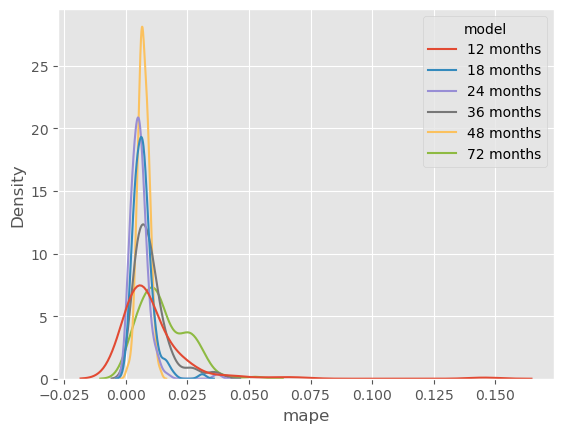

In [57]:
sns.kdeplot(data=atl_train_len_compare[~atl_train_len_compare['model'].isin(['6 months', '9 months', '96 months'])], x='mape', hue='model')
plt.show()

In [40]:
barplot_atl_train_split = atl_train_len_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
# barplot_atl_train_split.sort_values('mape')
barplot_atl_train_split.index = [2,3,4,5,6,0,7,1,8]
barplot_atl_train_split.sort_index()

,model,mape,rmse,mae
0,6 months,0.022821,5.417647,4.538170
1,9 months,0.012909,2.993971,2.556974
2,12 months,0.011263,2.596961,2.216817
3,18 months,0.006996,1.595564,1.402684
4,24 months,0.005711,1.278933,1.154923
5,36 months,0.010173,2.312964,2.067148
6,48 months,0.007282,1.970764,1.477938
7,72 months,0.015212,3.320917,3.080371
8,96 months,0.022659,4.871332,4.631700


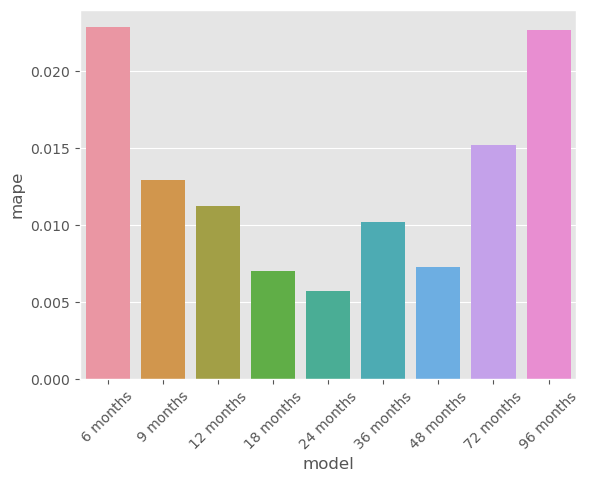

In [41]:
sns.barplot(data=barplot_atl_train_split.sort_index(), x='model', y='mape')
plt.xticks(rotation = 45)
plt.show()

# Cleveland - by Zip Code

In [ ]:
# subset for Cleveland zip codes
df_cle = df.loc[df['census_cbsa_geoid'] == '12060'].copy()
df_cle.reset_index(drop=True, inplace=True)
df_cle

In [ ]:
# create models with different exogenous features
dfc1 = prophetize(df_cle, 'Benchmark')
dfc2 = prophetize(df_cle, 'MFR Occ', addl_reg=['mfr_occ'])
dfc3 = prophetize(df_cle, 'MFR Rent', addl_reg=['mfr_mean_rent'])
dfc4 = prophetize(df_cle, 'MFR Occ & Rent', addl_reg=['mfr_mean_rent', 'mfr_occ'])

In [ ]:
# concat results
cle_exo_compare = pd.concat([dfc1,dfc2,dfc3,dfc4]).reset_index(drop=True)
cle_exo_compare

In [ ]:
# commented out so I don't accidentally overwrite the pickle
# cle_exo_compare.to_pickle('cle_exo_compare.pkl')

In [18]:
# read pickle for compare
with open('cle_exo_compare.pkl', "rb") as f:
    cle_exo_compare = pickle.load(f)
    
cle_exo_compare

,zip_code,model,mape,mae,rmse
0,44001,Benchmark,0.023667,4.120750,4.193933
1,44011,Benchmark,0.023848,4.146448,4.205963
2,44012,Benchmark,0.022634,3.915531,3.976931
3,44017,Benchmark,0.024337,4.084813,4.186735
4,44021,Benchmark,0.021434,3.492593,3.667707
...,...,...,...,...,...
247,44212,MFR Occ & Rent,0.016302,2.737510,2.895117
248,44256,MFR Occ & Rent,0.018515,3.125658,3.384487
249,44281,MFR Occ & Rent,0.021997,3.800684,3.959933
250,44321,MFR Occ & Rent,0.009634,1.665188,1.829218


In [19]:
cle_exo_compare['model'].replace('Benchmark', 'Univariate', inplace=True)
cle_exo_compare['model'].replace('MFR Occ', 'MFR Occupancy', inplace=True)

In [20]:
cle_exo_compare.sort_values('mape')

,zip_code,model,mape,mae,rmse
222,44121,MFR Occ & Rent,0.002186,0.312279,0.490353
169,44133,MFR Rent,0.004503,0.758369,0.929614
232,44133,MFR Occ & Rent,0.004894,0.824453,0.984490
159,44121,MFR Rent,0.006378,0.910603,1.064301
220,44118,MFR Occ & Rent,0.007530,1.197094,1.468775
...,...,...,...,...,...
209,44105,MFR Occ & Rent,0.031691,6.535115,7.054252
83,44105,MFR Occupancy,0.032148,6.626278,7.020135
20,44105,Univariate,0.032733,6.746360,7.126981
238,44141,MFR Occ & Rent,0.034712,6.547274,7.820171


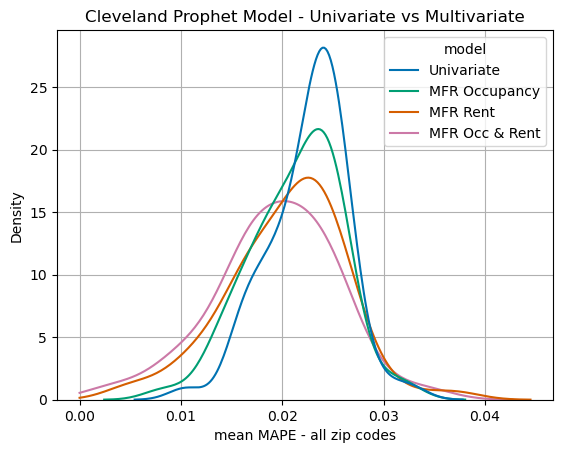

In [21]:
sns.kdeplot(data=cle_exo_compare, x='mape', hue='model', clip=(0,0.75))
plt.title('Cleveland Prophet Model - Univariate vs Multivariate')
plt.xlabel('mean MAPE - all zip codes')
plt.savefig('cle-proph-kde')
plt.show()

In [44]:
bar_plot_cle = cle_exo_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
bar_plot_cle.sort_values('mape', inplace=True)
bar_plot_cle

,model,mape,rmse,mae
2,MFR Occ & Rent,0.019350,3.468136,3.279389
3,MFR Rent,0.020443,3.650520,3.461084
1,MFR Occ,0.021368,3.771606,3.617384
0,Benchmark,0.022565,3.969770,3.818738


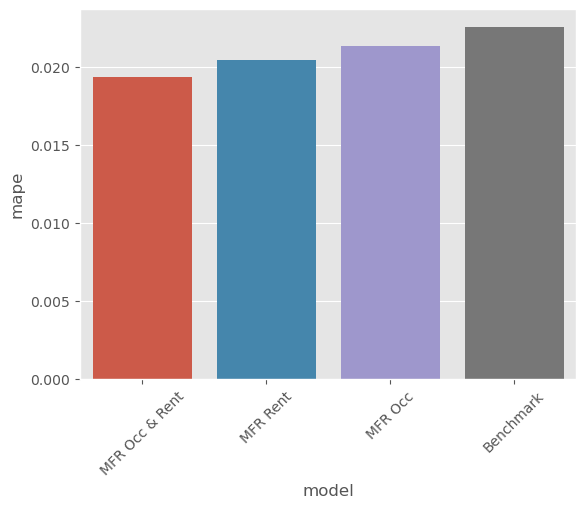

In [45]:
sns.barplot(data=bar_plot_cle, x='model', y='mape')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# run models for different time windows using both exogenous variables
dfc6 = prophetize(df_cle, '6 months',  train_start='2022-07-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc9 = prophetize(df_cle, '9 months',  train_start='2022-04-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc12= prophetize(df_cle, '12 months', train_start='2022-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc18= prophetize(df_cle, '18 months', train_start='2021-07-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc24= prophetize(df_cle, '24 months', train_start='2021-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc36= prophetize(df_cle, '36 months', train_start='2020-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc48= prophetize(df_cle, '48 months', train_start='2019-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])
dfc72= prophetize(df_cle, '72 months', train_start='2017-01-01', addl_reg=['mfr_mean_rent', 'mfr_occ'])

# pull from original model results
dfc96= cle_exo_compare.loc[cle_exo_compare['model'] == 'MFR Occ & Rent'].copy()

# rename model for consistency
dfc96['model'] = '96 months'

In [ ]:
cle_train_len_compare = pd.concat([dfc6,dfc9,dfc12,dfc18,dfc24,dfc36,dfc48,dfc72,dfc96]).reset_index(drop=True)
cle_train_len_compare

In [183]:
# commented out so I don't overwrite the pickle
# cle_train_len_compare.to_pickle('cle_train_length_splits.pkl')

In [23]:
with open('cle_train_length_splits.pkl', "rb") as f:
    cle_train_len_compare = pickle.load(f)

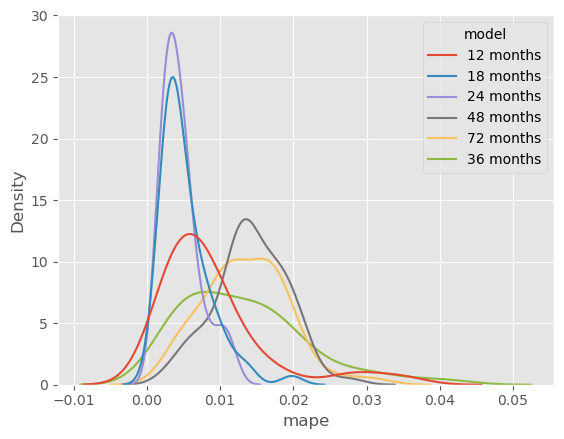

In [56]:
sns.kdeplot(data=cle_train_len_compare[~cle_train_len_compare['model'].isin(['9 months', '6 months', '96 months'])], x='mape', hue='model')
plt.show()

In [25]:
cle_train_len_compare

,zip_code,model,mape,mae,rmse
63,44001,6 months,0.013967,2.443389,2.947697
64,44011,6 months,0.004405,0.764836,0.806112
65,44012,6 months,0.004622,0.800830,0.944535
66,44017,6 months,0.006586,1.102167,1.197040
67,44021,6 months,0.001390,0.226442,0.291777
...,...,...,...,...,...
625,44212,96 months,0.016302,2.737510,2.895117
626,44256,96 months,0.018515,3.125658,3.384487
627,44281,96 months,0.021997,3.800684,3.959933
628,44321,96 months,0.009634,1.665188,1.829218


In [54]:
barplot_cle_train_split = cle_train_len_compare.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
# barplot_cle_train_split.sort_values('mape')
barplot_cle_train_split.index = [2,3,4,5,6,0,7,1,8]
barplot_cle_train_split

,model,mape,rmse,mae
2,12 months,0.008970,1.795358,1.513731
3,18 months,0.005275,1.054177,0.887308
4,24 months,0.004622,0.922357,0.781251
5,36 months,0.013249,2.519153,2.212742
6,48 months,0.014209,2.679511,2.393077
0,6 months,0.031166,6.540402,5.211837
7,72 months,0.013512,2.486436,2.300685
1,9 months,0.017906,3.503629,2.955963
8,96 months,0.019350,3.468136,3.279389


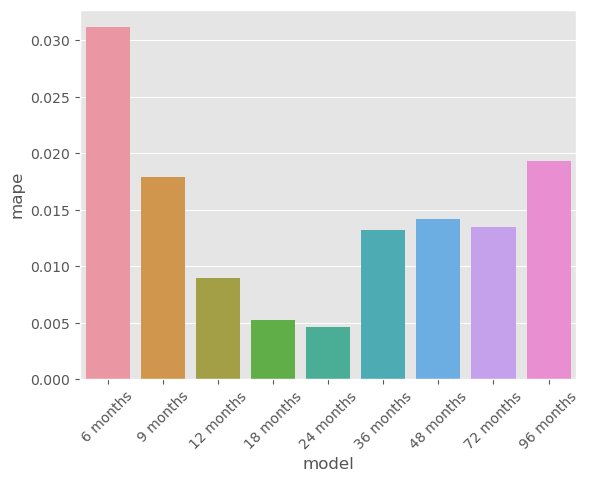

In [55]:
sns.barplot(data=barplot_cle_train_split.sort_index(), x='model', y='mape')
plt.xticks(rotation = 45)
plt.show()

In [34]:
train_len_compare_all = pd.concat([atl_train_len_compare,cle_train_len_compare])
train_len_compare_all['market'] = train_len_compare_all['zip_code'].apply(lambda x: 'Atlanta' if x.startswith('3') else 'Cleveland')

In [35]:
train_len_compare_all

,zip_code,model,mape,mae,rmse,market
0,30002,6 months,0.055323,10.617766,12.404984,Atlanta
1,30004,6 months,0.008169,1.524162,1.820664,Atlanta
2,30005,6 months,0.004522,0.873381,1.533561,Atlanta
3,30008,6 months,0.005805,1.196234,1.285248,Atlanta
4,30009,6 months,0.003828,0.771853,0.884304,Atlanta
...,...,...,...,...,...,...
625,44212,96 months,0.016302,2.737510,2.895117,Cleveland
626,44256,96 months,0.018515,3.125658,3.384487,Cleveland
627,44281,96 months,0.021997,3.800684,3.959933,Cleveland
628,44321,96 months,0.009634,1.665188,1.829218,Cleveland


In [38]:
barplot_train_len = train_len_compare_all.groupby('model', as_index=False)[['mape','rmse', 'mae']].mean()
barplot_train_len.index = [2,3,4,5,6,0,7,1,8]


In [43]:
barplot_train_len['model'] = barplot_train_len['model'].apply(lambda x: x[:len(x)-7])

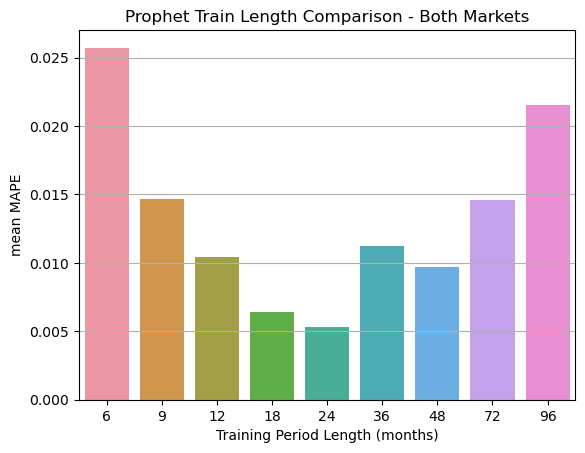

In [47]:
sns.barplot(data=barplot_train_len.sort_index(), x='model', y='mape')
plt.ylabel('mean MAPE')
plt.xlabel('Training Period Length (months)')
plt.title('Prophet Train Length Comparison - Both Markets')
plt.savefig('train-len')
plt.show()

# Cross Val

In [109]:
# create blocked time series class 
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, tr_size=24, tt_size=6):
        self.n_splits = n_splits
        self.tr_size = tr_size
        self.tt_size = tt_size
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = self.tr_size + self.tt_size
        indices = np.arange(n_samples)

        margin = 0
        for i in np.linspace(0,n_samples-k_fold_size,self.n_splits, dtype='int'):
            start = i
            stop = start + k_fold_size
            mid = start + (k_fold_size - self.tt_size) 
            yield indices[start: mid], indices[mid + margin: stop]

In [121]:
test = df.loc[df['census_zcta5_geoid'] == '30309']

In [137]:
cv = BlockingTimeSeriesSplit(4, tr_size=24)

In [138]:
for tr,tt in cv.split(test):
    print(tr)
    print(tt)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[24 25 26 27 28 29]
[24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51 52 53]
[48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77]
[72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[ 96  97  98  99 100 101]


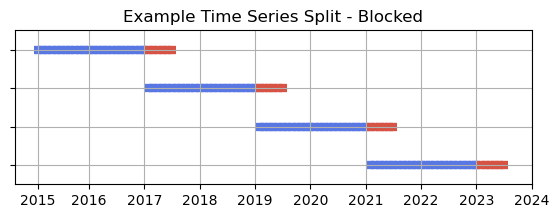

In [150]:
fig, ax = plt.subplots(figsize=(6.67,2))
for ii, (tr,tt) in enumerate(cv.split(test)):
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[3.5, -0.5])
plt.xticks(ticks=[0,11,23,35,47,59,71,83,95,107], labels=['2015','2016','2017','2018','2019','2020','2021','2022','2023','2024'])
plt.yticks(ticks=[3,2,1,0], labels=['','','',''])
plt.title('Example Time Series Split - Blocked')
plt.savefig('cv')

In [217]:
def prophetize_cv(df, label, y='sfr_rental_index', ds='date', addl_reg=[], splits=4, train_size=24, test_size=6):
    
    # cross_validate
    cv = BlockingTimeSeriesSplit(splits, tr_size=train_size, tt_size=test_size)
    
    
    # copy dataframe
    df_cv = df.copy()
    
    # rename columns for modeling
    df_cv.rename(columns = {
        ds:'ds',
        y:'y'
    }, inplace=True)
        
    # create results dictionary 
    result = {
        'zip_code':[],
        'model':[],
        'mape':[],
        'mae':[],
        'rmse':[]
    }
    i = 0
    for z in df_cv['census_zcta5_geoid'].unique():
                
        # subset for zip code
        df_cz = df_cv.loc[(df_cv['census_zcta5_geoid'] == z)]

        mapes = []
        maes = []
        rmses = []
        
        for ii , (tr, tt) in enumerate(cv.split(df_cz)):
            
            
            train = df_cz.iloc[tr]
            test = df_cz.iloc[tt]
            
            
            # instantiate and fit model
            m = Prophet() 
            for r in addl_reg:
                m.add_regressor(r)
            m.fit(train[['ds', 'y'] + addl_reg]) # fit model

            # create future dataframe
            future = df_cz[['ds'] + addl_reg]

            # create forecast
            forecast = m.predict(future)

            # calculate MAE and MSE
            mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[tt,'yhat']))
            mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[tt,'yhat']))
            rmse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[tt,'yhat']), squared=False)
            
            # mapes.append(mape)
            # maes.append(mae)
            # rmses.append(rmse)
            

            # add to dict
            result['zip_code'].append(z)
            result['model'].append(label)
            result['mape'].append(mape)
            result['mae'].append(mae)
            result['rmse'].append(rmse)
            
#             result['mape'].append(np.mean(mapes))
#             result['mae'].append(np.mean(maes))
#             result['rmse'].append(np.mean(rmses))
    return pd.DataFrame.from_dict(result)

In [218]:
df_all_cv_24 = prophetize_cv(df, 'CV - 24 months', \
                             addl_reg=['mfr_mean_rent', 'mfr_occ'], train_size=24)

16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:43:58 - cmdstanpy - INFO - Chain [1] done processing
16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:43:58 - cmdstanpy - INFO - Chain [1] done processing
16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:43:58 - cmdstanpy - INFO - Chain [1] done processing
16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:43:58 - cmdstanpy - INFO - Chain [1] done processing
16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:43:59 - cmdstanpy - INFO - Chain [1] done processing
16:43:59 - cmdstanpy - INFO - Chain [1] start processing
16:43:59 - cmdstanpy - INFO - Chain [1] done processing
16:43:59 - cmdstanpy - INFO - Chain [1] start processing
16:43:59 - cmdstanpy - INFO - Chain [1] done processing
16:43:59 - cmdstanpy - INFO - Chain [1] start processing
16:43:59 - cmdstanpy - INFO - Chain [1] done processing
16:43:59 - cmdstanpy - INFO - Chain [1] start processing
16:43:59 - cmdstanpy - INFO - Chain [1]

16:44:13 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:14 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:14 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:14 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:14 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:15 - cmdstanpy - INFO - Chain [1] done processing
16:44:15 - cmdstanpy - INFO - Chain [1] start processing
16:44:15 - cmdstanpy - INFO - Chain [1] done processing
16:44:15 - cmdstanpy - INFO - Chain [1] start processing
16:44:15 - cmdstanpy - INFO - Chain [1] done processing
16:44:15 - cmdstanpy - INFO - Chain [1] start processing
16:44:15 - cmdstanpy - INFO - Chain [1] done processing
16:44:15 - cmdstanpy - INFO - Chain [1] 

16:44:29 - cmdstanpy - INFO - Chain [1] done processing
16:44:29 - cmdstanpy - INFO - Chain [1] start processing
16:44:30 - cmdstanpy - INFO - Chain [1] done processing
16:44:30 - cmdstanpy - INFO - Chain [1] start processing
16:44:30 - cmdstanpy - INFO - Chain [1] done processing
16:44:30 - cmdstanpy - INFO - Chain [1] start processing
16:44:30 - cmdstanpy - INFO - Chain [1] done processing
16:44:30 - cmdstanpy - INFO - Chain [1] start processing
16:44:30 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1] done processing
16:44:32 - cmdstanpy - INFO - Chain [1] 

16:44:46 - cmdstanpy - INFO - Chain [1] done processing
16:44:46 - cmdstanpy - INFO - Chain [1] start processing
16:44:46 - cmdstanpy - INFO - Chain [1] done processing
16:44:46 - cmdstanpy - INFO - Chain [1] start processing
16:44:46 - cmdstanpy - INFO - Chain [1] done processing
16:44:46 - cmdstanpy - INFO - Chain [1] start processing
16:44:47 - cmdstanpy - INFO - Chain [1] done processing
16:44:47 - cmdstanpy - INFO - Chain [1] start processing
16:44:47 - cmdstanpy - INFO - Chain [1] done processing
16:44:47 - cmdstanpy - INFO - Chain [1] start processing
16:44:47 - cmdstanpy - INFO - Chain [1] done processing
16:44:47 - cmdstanpy - INFO - Chain [1] start processing
16:44:47 - cmdstanpy - INFO - Chain [1] done processing
16:44:47 - cmdstanpy - INFO - Chain [1] start processing
16:44:47 - cmdstanpy - INFO - Chain [1] done processing
16:44:47 - cmdstanpy - INFO - Chain [1] start processing
16:44:47 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] 

16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:03 - cmdstanpy - INFO - Chain [1] start processing
16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:03 - cmdstanpy - INFO - Chain [1] start processing
16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:03 - cmdstanpy - INFO - Chain [1] start processing
16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:03 - cmdstanpy - INFO - Chain [1] start processing
16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:04 - cmdstanpy - INFO - Chain [1] start processing
16:45:04 - cmdstanpy - INFO - Chain [1] done processing
16:45:04 - cmdstanpy - INFO - Chain [1] start processing
16:45:04 - cmdstanpy - INFO - Chain [1] done processing
16:45:04 - cmdstanpy - INFO - Chain [1] start processing
16:45:04 - cmdstanpy - INFO - Chain [1] done processing
16:45:04 - cmdstanpy - INFO - Chain [1] start processing
16:45:04 - cmdstanpy - INFO - Chain [1] done processing
16:45:04 - cmdstanpy - INFO - Chain [1] 

16:45:19 - cmdstanpy - INFO - Chain [1] done processing
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:19 - cmdstanpy - INFO - Chain [1] done processing
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:19 - cmdstanpy - INFO - Chain [1] done processing
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:19 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:20 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:21 - cmdstanpy - INFO - Chain [1] start processing
16:45:21 - cmdstanpy - INFO - Chain [1] done processing
16:45:21 - cmdstanpy - INFO - Chain [1] 

16:45:35 - cmdstanpy - INFO - Chain [1] done processing
16:45:35 - cmdstanpy - INFO - Chain [1] start processing
16:45:35 - cmdstanpy - INFO - Chain [1] done processing
16:45:35 - cmdstanpy - INFO - Chain [1] start processing
16:45:35 - cmdstanpy - INFO - Chain [1] done processing
16:45:35 - cmdstanpy - INFO - Chain [1] start processing
16:45:35 - cmdstanpy - INFO - Chain [1] done processing
16:45:35 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing
16:45:36 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing
16:45:36 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing
16:45:36 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing
16:45:36 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing
16:45:36 - cmdstanpy - INFO - Chain [1] 

16:45:50 - cmdstanpy - INFO - Chain [1] done processing
16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:51 - cmdstanpy - INFO - Chain [1] done processing
16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:51 - cmdstanpy - INFO - Chain [1] done processing
16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:51 - cmdstanpy - INFO - Chain [1] done processing
16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing
16:45:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing
16:45:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing
16:45:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing
16:45:52 - cmdstanpy - INFO - Chain [1] start processing
16:45:52 - cmdstanpy - INFO - Chain [1] done processing
16:45:52 - cmdstanpy - INFO - Chain [1] 

16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:08 - cmdstanpy - INFO - Chain [1] start processing
16:46:08 - cmdstanpy - INFO - Chain [1] done processing
16:46:08 - cmdstanpy - INFO - Chain [1] start processing
16:46:08 - cmdstanpy - INFO - Chain [1] done processing
16:46:08 - cmdstanpy - INFO - Chain [1] start processing
16:46:08 - cmdstanpy - INFO - Chain [1] done processing
16:46:08 - cmdstanpy - INFO - Chain [1] start processing
16:46:08 - cmdstanpy - INFO - Chain [1] done processing
16:46:08 - cmdstanpy - INFO - Chain [1] 

16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:22 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing
16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:23 - cmdstanpy - INFO - Chain [1] done processing
16:46:23 - cmdstanpy - INFO - Chain [1] 

In [219]:
df_all_cv_18 = prophetize_cv(df, 'CV - 18 months', \
                             addl_reg=['mfr_mean_rent', 'mfr_occ'], train_size=18)

16:46:35 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1] done processing
16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1] done processing
16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:37 - cmdstanpy - INFO - Chain [1]

16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:52 - cmdstanpy - INFO - Chain [1] 

16:47:04 - cmdstanpy - INFO - Chain [1] done processing
16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:04 - cmdstanpy - INFO - Chain [1] done processing
16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:04 - cmdstanpy - INFO - Chain [1] done processing
16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:05 - cmdstanpy - INFO - Chain [1] done processing
16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:05 - cmdstanpy - INFO - Chain [1] done processing
16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:05 - cmdstanpy - INFO - Chain [1] done processing
16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:05 - cmdstanpy - INFO - Chain [1] done processing
16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:05 - cmdstanpy - INFO - Chain [1] done processing
16:47:05 - cmdstanpy - INFO - Chain [1] start processing
16:47:06 - cmdstanpy - INFO - Chain [1] done processing
16:47:06 - cmdstanpy - INFO - Chain [1] 

16:47:18 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:19 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] 

16:47:32 - cmdstanpy - INFO - Chain [1] done processing
16:47:32 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:34 - cmdstanpy - INFO - Chain [1] done processing
16:47:34 - cmdstanpy - INFO - Chain [1] start processing
16:47:34 - cmdstanpy - INFO - Chain [1] done processing
16:47:34 - cmdstanpy - INFO - Chain [1] start processing
16:47:34 - cmdstanpy - INFO - Chain [1] done processing
16:47:34 - cmdstanpy - INFO - Chain [1] 

16:47:46 - cmdstanpy - INFO - Chain [1] done processing
16:47:46 - cmdstanpy - INFO - Chain [1] start processing
16:47:46 - cmdstanpy - INFO - Chain [1] done processing
16:47:46 - cmdstanpy - INFO - Chain [1] start processing
16:47:46 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:47 - cmdstanpy - INFO - Chain [1] done processing
16:47:48 - cmdstanpy - INFO - Chain [1] 

16:47:59 - cmdstanpy - INFO - Chain [1] done processing
16:47:59 - cmdstanpy - INFO - Chain [1] start processing
16:47:59 - cmdstanpy - INFO - Chain [1] done processing
16:47:59 - cmdstanpy - INFO - Chain [1] start processing
16:47:59 - cmdstanpy - INFO - Chain [1] done processing
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:00 - cmdstanpy - INFO - Chain [1] done processing
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:00 - cmdstanpy - INFO - Chain [1] done processing
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:00 - cmdstanpy - INFO - Chain [1] done processing
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:00 - cmdstanpy - INFO - Chain [1] done processing
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:00 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] 

16:48:14 - cmdstanpy - INFO - Chain [1] done processing
16:48:14 - cmdstanpy - INFO - Chain [1] start processing
16:48:14 - cmdstanpy - INFO - Chain [1] done processing
16:48:14 - cmdstanpy - INFO - Chain [1] start processing
16:48:14 - cmdstanpy - INFO - Chain [1] done processing
16:48:14 - cmdstanpy - INFO - Chain [1] start processing
16:48:14 - cmdstanpy - INFO - Chain [1] done processing
16:48:14 - cmdstanpy - INFO - Chain [1] start processing
16:48:15 - cmdstanpy - INFO - Chain [1] done processing
16:48:15 - cmdstanpy - INFO - Chain [1] start processing
16:48:15 - cmdstanpy - INFO - Chain [1] done processing
16:48:15 - cmdstanpy - INFO - Chain [1] start processing
16:48:15 - cmdstanpy - INFO - Chain [1] done processing
16:48:15 - cmdstanpy - INFO - Chain [1] start processing
16:48:15 - cmdstanpy - INFO - Chain [1] done processing
16:48:15 - cmdstanpy - INFO - Chain [1] start processing
16:48:15 - cmdstanpy - INFO - Chain [1] done processing
16:48:16 - cmdstanpy - INFO - Chain [1] 

16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:30 - cmdstanpy - INFO - Chain [1] start processing
16:48:30 - cmdstanpy - INFO - Chain [1] done processing
16:48:30 - cmdstanpy - INFO - Chain [1] start processing
16:48:30 - cmdstanpy - INFO - Chain [1] done processing
16:48:30 - cmdstanpy - INFO - Chain [1] 

16:48:42 - cmdstanpy - INFO - Chain [1] done processing
16:48:42 - cmdstanpy - INFO - Chain [1] start processing
16:48:42 - cmdstanpy - INFO - Chain [1] done processing
16:48:42 - cmdstanpy - INFO - Chain [1] start processing
16:48:42 - cmdstanpy - INFO - Chain [1] done processing
16:48:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:43 - cmdstanpy - INFO - Chain [1] done processing
16:48:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:43 - cmdstanpy - INFO - Chain [1] done processing
16:48:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:43 - cmdstanpy - INFO - Chain [1] done processing
16:48:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:43 - cmdstanpy - INFO - Chain [1] done processing
16:48:43 - cmdstanpy - INFO - Chain [1] start processing
16:48:43 - cmdstanpy - INFO - Chain [1] done processing
16:48:44 - cmdstanpy - INFO - Chain [1] start processing
16:48:44 - cmdstanpy - INFO - Chain [1] done processing
16:48:44 - cmdstanpy - INFO - Chain [1] 

In [221]:
df_all_cv = pd.concat([df_all_cv_18, df_all_cv_24]).reset_index(drop=True)

In [222]:
# commented out so I don't overwrite the pickle
# df_all_cv.to_pickle('cv_all.pkl')

In [103]:
with open('cv_all.pkl', "rb") as f:
    df_all_cv = pickle.load(f)

In [104]:
train_len_compare_all['zip_code'].apply(lambda x: 'Atlanta' if x.startswith('3') else 'Cleveland')

0        Atlanta
1        Atlanta
2        Atlanta
3        Atlanta
4        Atlanta
         ...    
625    Cleveland
626    Cleveland
627    Cleveland
628    Cleveland
629    Cleveland
Name: zip_code, Length: 1629, dtype: object

In [105]:
df_all_cv['Market'] = df_all_cv['zip_code'].apply(lambda x: 'Atlanta' if x.startswith('3') else 'Cleveland')

In [106]:
df_all_cv

,zip_code,model,mape,mae,rmse,Market
0,30002,CV - 18 months,0.007805,0.982264,1.177046,Atlanta
1,30002,CV - 18 months,0.013968,1.953097,2.368574,Atlanta
2,30002,CV - 18 months,0.006899,1.091653,1.528999,Atlanta
3,30002,CV - 18 months,0.007583,1.453249,1.491572,Atlanta
4,30004,CV - 18 months,0.007668,0.951052,1.080922,Atlanta
...,...,...,...,...,...,...
1443,44321,CV - 24 months,0.002140,0.370309,0.444218,Cleveland
1444,44333,CV - 24 months,0.014351,1.745672,2.169324,Cleveland
1445,44333,CV - 24 months,0.001761,0.228537,0.307502,Cleveland
1446,44333,CV - 24 months,0.003772,0.554824,0.751165,Cleveland


In [107]:
# df_all_cv['model'] = 
df_all_cv['model'] = df_all_cv['model'].apply(lambda x: x[5:])
df_all_cv

,zip_code,model,mape,mae,rmse,Market
0,30002,18 months,0.007805,0.982264,1.177046,Atlanta
1,30002,18 months,0.013968,1.953097,2.368574,Atlanta
2,30002,18 months,0.006899,1.091653,1.528999,Atlanta
3,30002,18 months,0.007583,1.453249,1.491572,Atlanta
4,30004,18 months,0.007668,0.951052,1.080922,Atlanta
...,...,...,...,...,...,...
1443,44321,24 months,0.002140,0.370309,0.444218,Cleveland
1444,44333,24 months,0.014351,1.745672,2.169324,Cleveland
1445,44333,24 months,0.001761,0.228537,0.307502,Cleveland
1446,44333,24 months,0.003772,0.554824,0.751165,Cleveland


In [144]:
df_all_cv['model'] = df_all_cv["model"] + ' CV'

In [145]:
df_all_cv.sort_values('mape')

,zip_code,model,mape,mae,rmse,Market
933,30122,24 months CV,0.000404,0.055566,0.062034,Atlanta
469,30519,18 months CV,0.000707,0.096326,0.110769,Atlanta
55,30033,18 months CV,0.000801,0.145222,0.188010,Atlanta
799,30040,24 months CV,0.000832,0.154835,0.192509,Atlanta
1020,30281,24 months CV,0.000848,0.108952,0.163458,Atlanta
...,...,...,...,...,...,...
236,30180,18 months CV,0.068157,8.429529,9.654308,Atlanta
385,30326,18 months CV,0.077429,10.479596,11.454150,Atlanta
306,30294,18 months CV,0.089446,14.962336,16.101486,Atlanta
353,30313,18 months CV,0.141757,19.753154,21.734405,Atlanta


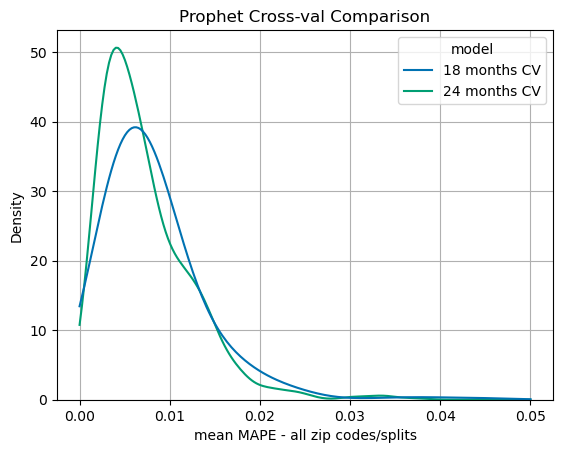

In [148]:
sns.kdeplot(data=df_all_cv, x='mape', hue='model', clip=(0,0.05))
plt.xlabel('mean MAPE - all zip codes/splits')
plt.title('Prophet Cross-val Comparison')
plt.savefig('cv_kde')
plt.show()